## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [251]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
import math

In [252]:
env = TicTacToe()

In [253]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [254]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
env = TicTacToe()
def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [255]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = Q_state(state)
    
    valid_act = valid_actions(state)
    if state_key not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state_key][action]=0

In [256]:
#Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
def reset_dicts():
    Q_dict = collections.defaultdict(dict)

    States_track = collections.defaultdict(dict)

    print('Q_dict size : {}'.format(len(Q_dict)))
    print('States_track size : {}'.format(len(States_track)))
    
    return Q_dict, States_track

In [257]:
# Initialise states to be tracked
def initialise_tracking_states():
    #select any 4 Q-values
    sample_q_values = [([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(0,1)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(2,3)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(4,5)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(6,7)),
                       ([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(8,9))]    
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        # this is an array which will have appended values of that state-action pair for 
        # every threshold value episode         
        States_track[state][action] = []

In [258]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [259]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time, debug = False):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = (min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time))
    
    if debug:
        print('Epsilon Value : {}'.format(epsilon))
        
    z = np.random.random()
        
    if z > epsilon:
        # Exploitation: this gets the action corresponding to max q-value of current state
        state_key = Q_state(state)
        action = max(Q_dict[state_key],key=Q_dict[state_key].get)
        if debug:
            print('Exploitation Action : {}'.format(action))
    else:
        # Exploration: randomly choosing and action
        action = random.choice(valid_actions(state)) 
        if debug:
            print('Exploration Action : {}'.format(action))
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [260]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
print(len(Q_dict))
print(len(States_track))

0
0


In [261]:
# Initialise states to be tracked
#def initialise_tracking_states():
#    sample_q_values = [('x-x-x-4-x-3-x-x-x',(0, 1)),('3-x-6-x-4-x-x-x-7',(6, 5)),#taking 4 sample state-actions 
#                       ('x-x-5-x-8-9-x-x-4',(0, 3)),('x-1-x-3-x-2-x-x-4',(2, 7))]
#    for q_value in sample_q_values:
#        state = q_value[0]
#        action = q_value[1]
#        #state1 = Q_state(state)
#        States_track[state][action] = []  

In [262]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [263]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [264]:
Q_dict, States_track = reset_dicts()
initialise_tracking_states()

Q_dict size : 0
States_track size : 0


In [265]:
# Defining a function which will add new Q-values to the Q-dictionary. 
episode_position_dict = collections.defaultdict(dict)
def add_to_episode_action_position(episode):
    for position in range(9):
        episode_position_dict[episode][position]=0

#### Define hyperparameters  ---write your code here

In [266]:
EPISODES = 500000
threshold = 50
policy_threshold = 500
debug = False
LR = 0.01                   #learning rate
GAMMA = 0.91

### Q-update loop ---write your code here

In [267]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
    Terminal = False
    add_to_dict(curr_state)
    total_reward = 0
    reward = None
    
    while not Terminal:
        current_state_str = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, Terminal = env.step(curr_state, curr_action)
        
        next_state_str = Q_state(next_state)
        add_to_dict(next_state)
        
        if not Terminal:
            max_next = max(Q_dict[next_state_str],key=Q_dict[next_state_str].get)#this gives the action corresponding to max q-value of next state
            Q_dict[current_state_str][curr_action] += LR * ((reward + (GAMMA * (Q_dict[next_state_str][max_next]))) -
                Q_dict[current_state_str][curr_action])
        else:
            Q_dict[current_state_str][curr_action] += LR * ((reward - Q_dict[current_state_str][curr_action]))
        
        curr_state = next_state
        total_reward += reward
        
     #TRACKING Q-VALUES
    if (episode == threshold-1):        #at 3999 episodes
        initialise_tracking_states()

    if ((episode + 1) % threshold) == 0:   #4000 episodes
        save_tracking_states()
        save_obj(States_track,'States_tracked')
    
    #SAVING POLICY
    if ((episode + 1)% policy_threshold ) == 0:  #40000 episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
       
    elapsed_time = time.time() - start_time
print("Episode: {}".format(episode))
print('Elapsed Time : {}'.format(elapsed_time))
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

Episode: 499999
Elapsed Time : 2215.460091114044


In [268]:
print(elapsed_time)

2215.460091114044


#### Check the Q-dictionary

In [269]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.1020148718419345,
              (0, 3): -1.1020253456990963,
              (0, 5): -1.1020205423740457,
              (0, 7): -1.103008798357144,
              (0, 9): -1.1019006490912278,
              (1, 1): -1.1023989687304252,
              (1, 3): -1.1018440369571778,
              (1, 5): -1.1021352084325424,
              (1, 7): -1.102498303686041,
              (1, 9): -1.1019732923986552,
              (2, 1): -1.1021998197108718,
              (2, 3): -1.1022105979880197,
              (2, 5): -1.103477602245022,
              (2, 7): -1.102271767141842,
              (2, 9): -1.101970185289787,
              (3, 1): -1.1024547149422481,
              (3, 3): -1.101916015518555,
              (3, 5): -1.102859990621957,
              (3, 7): -1.1020165527633807,
              (3, 9): -1.101936515237513,
              (4, 1): -1.1023908146257722,
              (4, 3): -1.1025044016840684,
              (4, 5): -

In [270]:
len(Q_dict)

960822

In [271]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
with open('Policy.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)

print(len(Q_dict))

960822


## Check States_track

### Reading States_tracked file¶


In [272]:
# Write the code for plotting the graphs for state-action pairs tracked

In [273]:
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

In [274]:
for key, value in States_track.items():
    for k,v in value.items():
        print('State - Action - Value : {} - {} - {}'.format(key, k, len(v)))

State - Action - Value : x-x-x-x-x-x-x-x-x - (0, 1) - 10000
State - Action - Value : x-x-x-x-x-x-x-x-x - (2, 3) - 10000
State - Action - Value : x-x-x-x-x-x-x-x-x - (4, 5) - 10000
State - Action - Value : x-x-x-x-x-x-x-x-x - (6, 7) - 10000
State - Action - Value : x-x-x-x-x-x-x-x-x - (8, 9) - 10000


### Plotting state actions

In [275]:
def plot_state_actions(last_tracked_count = None):        
    plt.figure(0, figsize=(20,10))
    for state in States_track.keys():
        for idx, action in enumerate(States_track[state]):
            plt.subplot(math.ceil(len(States_track[state]) / 3), 3, idx + 1)
            if not last_tracked_count:
                last_tracked_count = len(States_track[state][action])
            xaxis = np.asarray(range(0, len(States_track[state][action][(-1*last_tracked_count):])))
            plt.title('state={} action={}'.format(state, action))
            plt.plot(xaxis,np.asarray(States_track[state][action][(-1*last_tracked_count):]))

    plt.show()

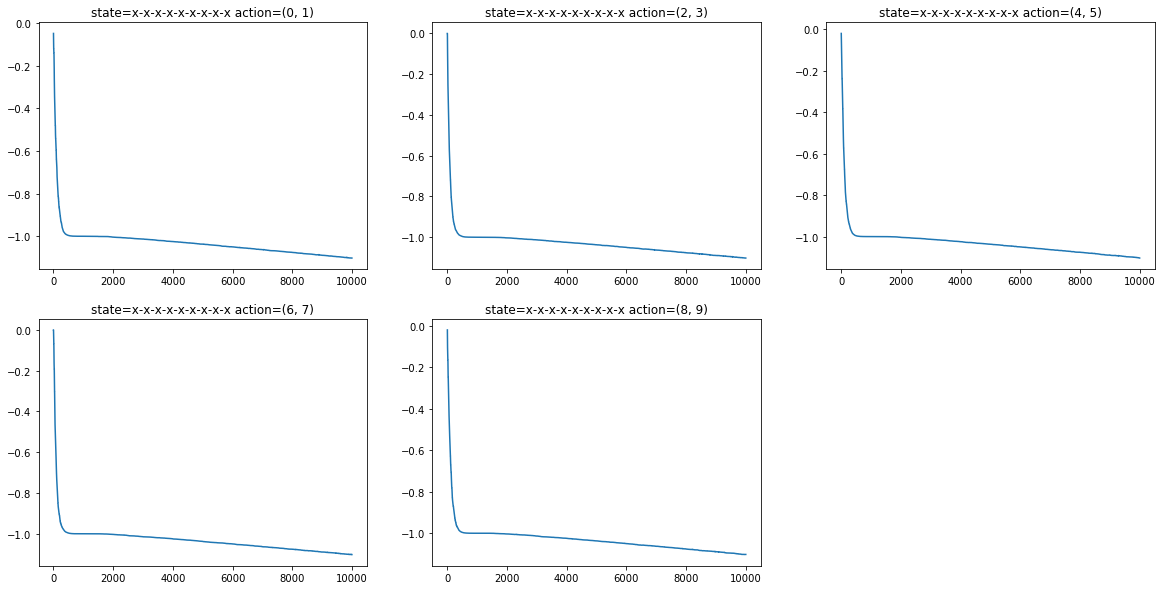

In [276]:
plot_state_actions()

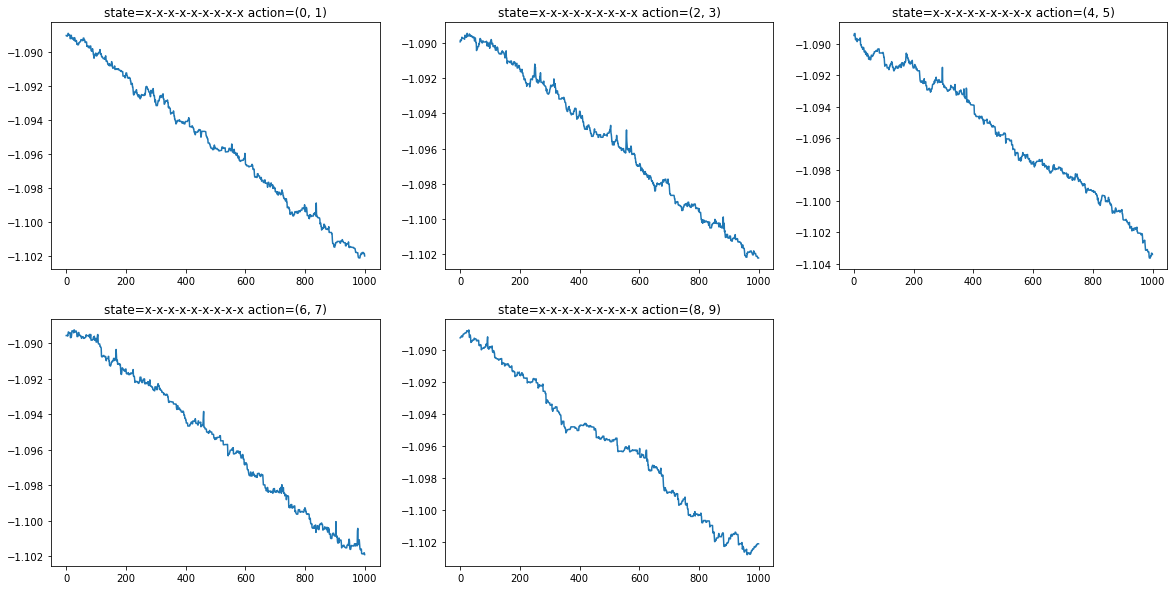

In [277]:
plot_state_actions(1000)

### Epsilon - decay check

In [278]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

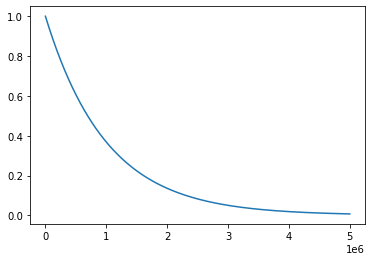

In [279]:
plt.plot(time, epsilon)
plt.show()